The problem that I will be tackling in this project involves **attempting to predict a given building's energy efficiency** (i.e. its heating and cooling load) based on its various physical characteristics, such as compactness, surface area, wall and roof areas, and more. The project's code is available at https://github.com/giosofteng/eep
<br><br>
This is a typical **Supervised Learning** problem, as all of our data is clearly labeled. The task is **Regression**, since we are trying to predict continuous values (heating and cooling loads).
<br><br>
The project's goal is to create a model that will accurately predict the energy efficiency of a planned building. Being able to make this estimate in advance ought to encourage the construction of more efficient buildings, promoting sustainability. Although the project itself is rather simple, it will hopefully still play a role in promoting sustainable building practices--something that was brought to my attention in Dr. Michael Readey's Finance for Technical Managers classes at CU Boulder.
<br><br><br>
The dataset that I used is called **Energy Efficiency** and is freely available at **UC Irvine's Machine Learning Repository**. The data, comprised of 768 samples and 8 features, is synthetic and was created using Autodesk's Ecotect.
<br><br>
Tsanas, A. & Xifara, A. (2012). Energy Efficiency [Dataset].
<br>
UCI Machine Learning Repository.
<br>
https://doi.org/10.24432/C51307.
<br><br>
The data is tabular and has 768 rows and 10 columns (8 features and 2 target labels). It is stored as a single table inside a 78 KB Excel spreadsheet.
<br><br>
The **features** are:
<br>
*Relative Compactness* (Continuous)
<br>
*Surface Area* (Continuous)
<br>
*Wall Area* (Continuous)
<br>
*Roof Area* (Continuous)
<br>
*Overall Height* (Continuous)
<br>
*Orientation* (Integer)
<br>
*Glazing Area* (Continuous)
<br>
*Glazing Area Distribution* (Integer)
<br><br>
The **target labels** are:
<br>
*Heating Load* (Continuous)
<br>
*Cooling Load* (Continuous)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Having imported all necessary libraries, let us now import our data and clean it as necessary.

In [2]:
df = pd.read_excel('./ENB2012_data.xlsx')
print(df.head())

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


As you can see, our column names use a non-descriptive X/Y nomenclature. Let us begin by changing said names to what they actually represent.

In [3]:
df.rename(columns={
    'X1': 'relative_compactness',
    'X2': 'surface_area',
    'X3': 'wall_area',
    'X4': 'roof_area',
    'X5': 'overall_height',
    'X6': 'orientation',
    'X7': 'glazing_area',
    'X8': 'glazing_area_distribution',
    'Y1': 'heating_load',
    'Y2': 'cooling_load'
}, inplace=True)
print(df.head())

   relative_compactness  surface_area  wall_area  roof_area  overall_height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   orientation  glazing_area  glazing_area_distribution  heating_load  \
0            2           0.0                          0         15.55   
1            3           0.0                          0         15.55   
2            4           0.0                          0         15.55   
3            5           0.0                          0         15.55   
4            2           0.0                          0         20.84   

   cooling_load  
0         21.33  
1         21.33  
2         21.33  
3         21.3

Our dataset is relatively clean e.g. it does not contain any missing values. However, let us go through some typical cleaning steps to make it a better fit for our particular use case. Let us begin by dropping any duplicate rows.

In [4]:
df.drop_duplicates(inplace=True)

Next, let us look for any outliers by generating and inspecting box plots for our columns.

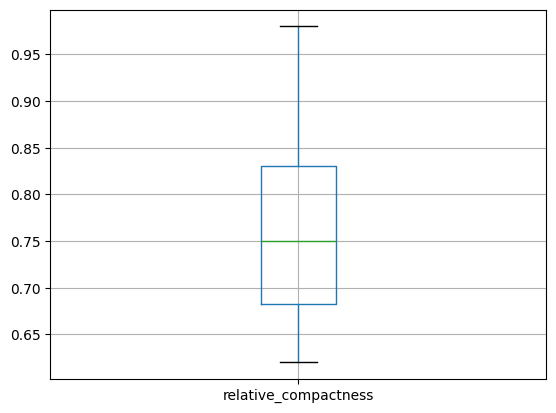

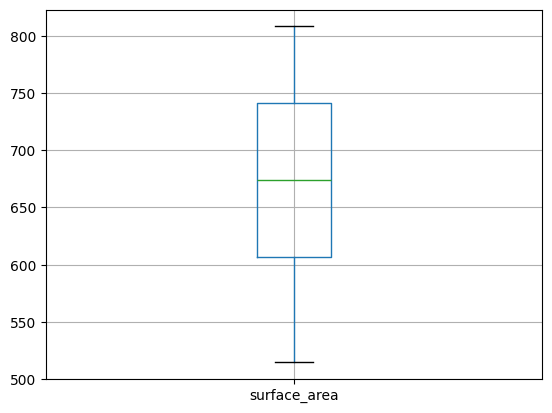

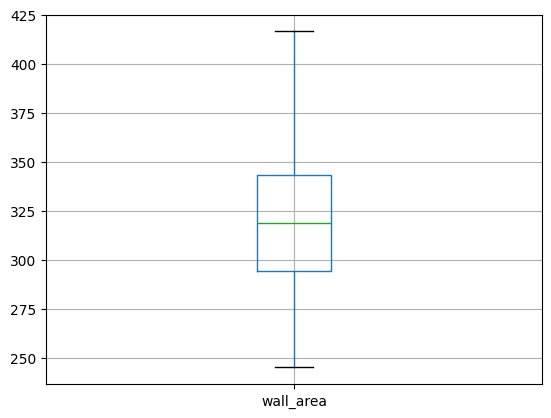

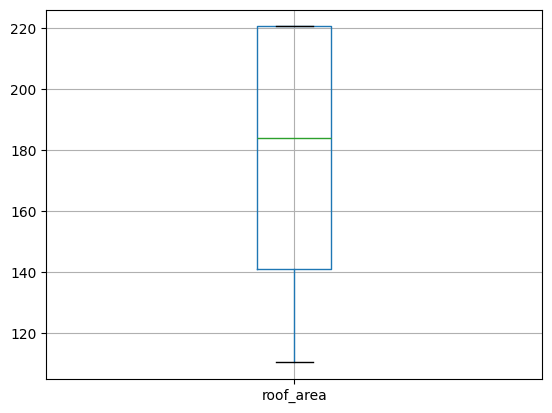

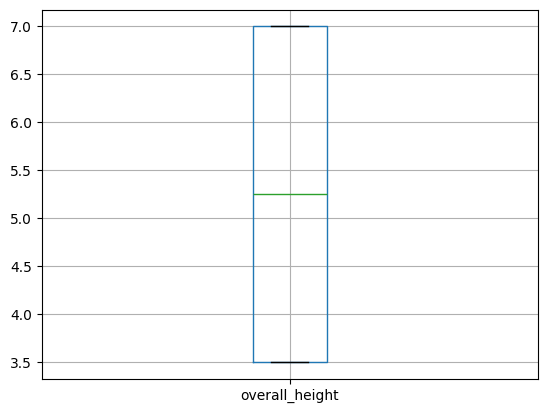

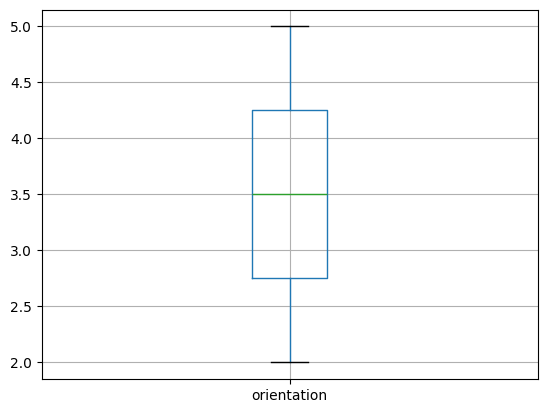

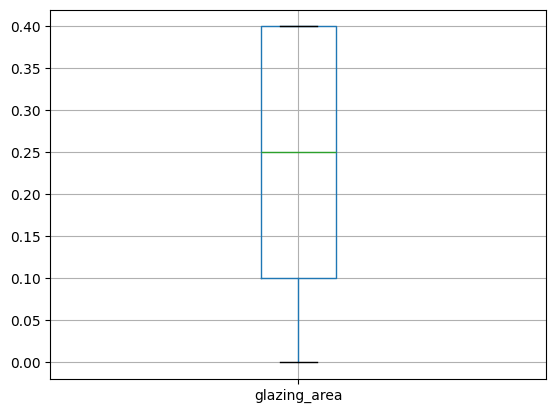

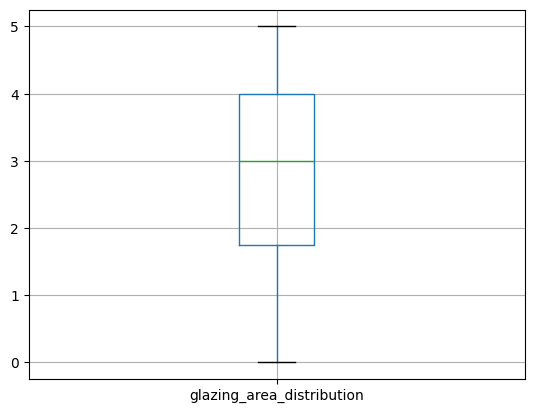

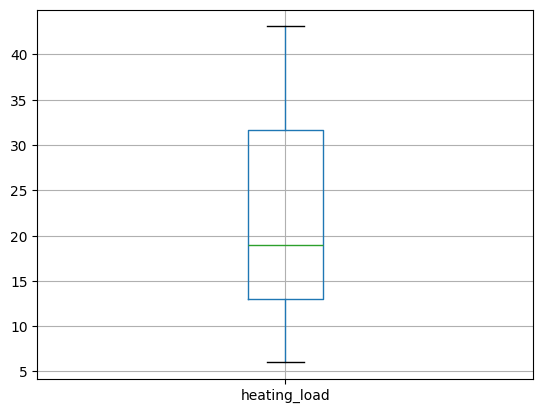

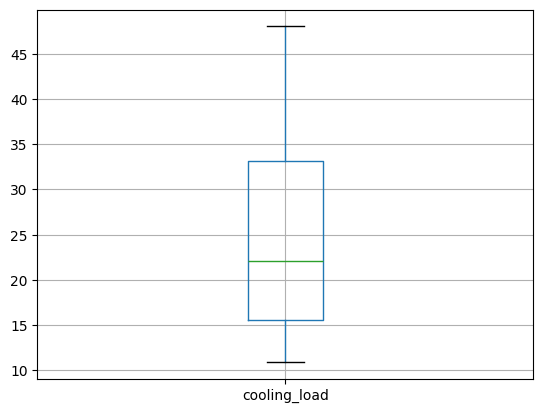

In [5]:
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        plt.figure()
        df.boxplot(column=[column])
        plt.show()

Looking at the above box plots, we do not seem to have any extreme outliers. I was initially worried about certain rows having a **Glazing Area** of 0 (for those that do not know, glazing area refers to the total area that glass surfaces occupy on a building). However, I then realized that certain facilities might be windowless or even be located entirely underground.
<br><br>
One problem that we do face, however, is that two of our columns, namely **Orientation** and **Glazing Area Distribution**, are actually categorical variables encoded as integers. Namely, the orientation has values of *2 (East), 3 (South), 4 (West), or 5 (North)*. These are cardinal directions. Meanwhile, the glazing area distribution denotes the number of window units that a building has and can be *0, 1, 2, 3, 4, or 5*. Rather than dropping these columns (they could be very important metrics--especially the building's orientation), I decided to use a technique called one-hot encoding, which creates a new binary column for each category (except the first, to avoid multicollinearity).

In [6]:
df = pd.get_dummies(df, columns=['orientation', 'glazing_area_distribution'], drop_first=True)
print(df.head())

   relative_compactness  surface_area  wall_area  roof_area  overall_height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   glazing_area  heating_load  cooling_load  orientation_3  orientation_4  \
0           0.0         15.55         21.33          False          False   
1           0.0         15.55         21.33           True          False   
2           0.0         15.55         21.33          False           True   
3           0.0         15.55         21.33          False          False   
4           0.0         20.84         28.28          False          False   

   orientation_5  glazing_area_distribution_1  glazing_area_di

So, to summarize, we took our relatively clean dataset, gave the columns meaningful names, removed potential duplicate rows, checked for any outliers, and dealt with categorical variables using one-hot encoding. As an added bonus, we discovered that not all buildings have windows! Now, with all of that behind us, let us conduct an EDA on our transformed dataset.
<br><br>
Let us begin our analysis by having another look at our data.

In [7]:
print('DATASET DIMENSIONS:')
print(df.shape)
print('-----------------------------------------------------------------')
print('COLUMN TYPES:')
print(df.dtypes)
print('-----------------------------------------------------------------')
print('BASIC STATISTICS:')
print(df.describe())

DATASET DIMENSIONS:
(768, 16)
-----------------------------------------------------------------
COLUMN TYPES:
relative_compactness           float64
surface_area                   float64
wall_area                      float64
roof_area                      float64
overall_height                 float64
glazing_area                   float64
heating_load                   float64
cooling_load                   float64
orientation_3                     bool
orientation_4                     bool
orientation_5                     bool
glazing_area_distribution_1       bool
glazing_area_distribution_2       bool
glazing_area_distribution_3       bool
glazing_area_distribution_4       bool
glazing_area_distribution_5       bool
dtype: object
-----------------------------------------------------------------
BASIC STATISTICS:
       relative_compactness  surface_area   wall_area   roof_area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167   

Everything seems to be in order--as expected. Next, let us visualize the numerical data using Histograms.

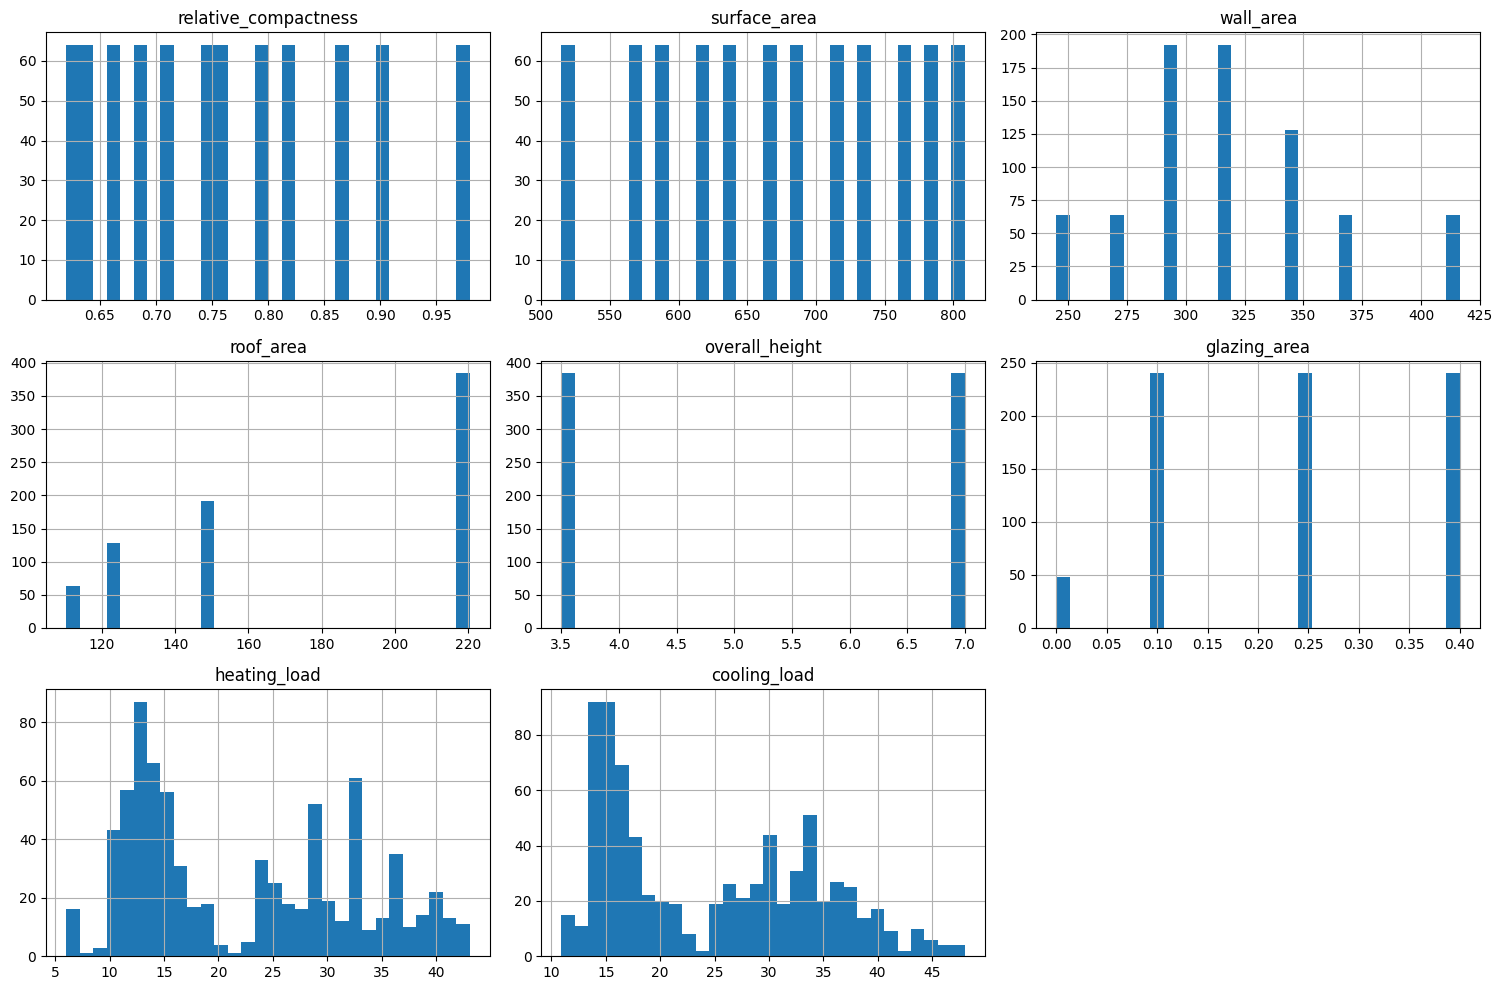

In [8]:
df.hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()

Let us also visualize the categorical data--this time using count plots.

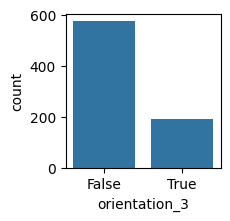

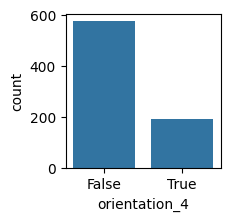

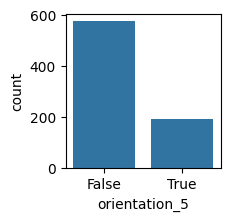

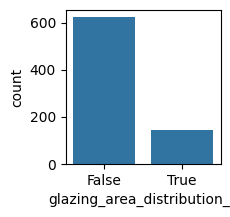

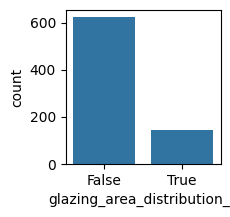

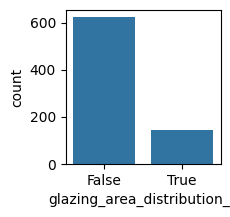

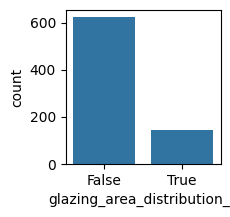

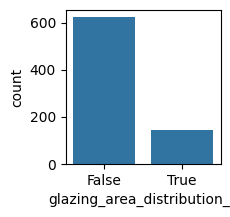

In [9]:
categorical_columns = ['orientation_3', 'orientation_4', 'orientation_5',
                       'glazing_area_distribution_1', 'glazing_area_distribution_2',
                       'glazing_area_distribution_3', 'glazing_area_distribution_4',
                       'glazing_area_distribution_5']
for column in categorical_columns:
    plt.figure(figsize=(2,2))
    sns.countplot(data=df, x=column)
    plt.show()

Let us now display a correlation matrix for all variables.

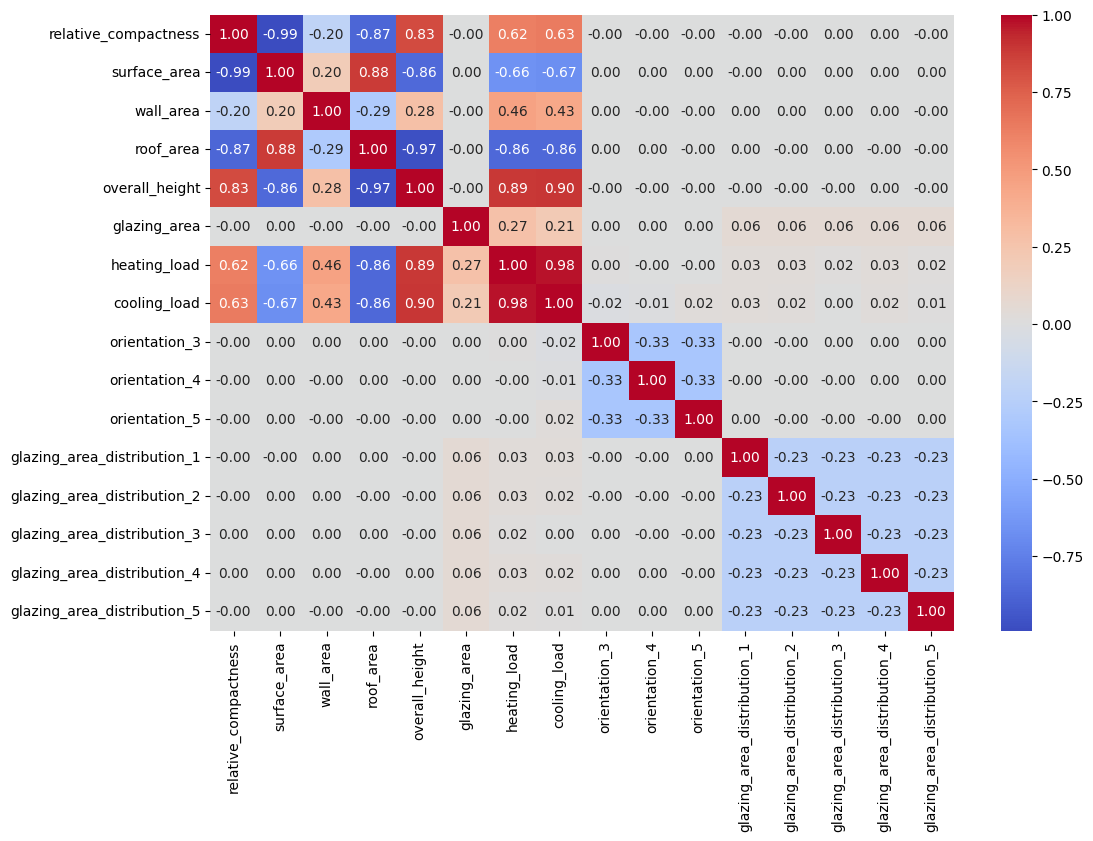

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Now then, let us try to draw some meaningful conclusions from our analysis. Looking at the features, we see a very strong negative correlation (-0.99) between **Surface Area** and **Relative Compactness**. This makes sense and means that we will not be using both in our model. Let us make the arbitrary choice of keeping the **Relative Compactness** over **Surface Area**. Furthermore, our two target variables, **Heating Load** and **Cooling Load** have a very strong positive correlation (0.98). Therefore, we will only keep one target--**Heating Load**. Lastly, although we see weak correlation between our binary and continuous variables, this is actually normal behavior when using one-hot encoding. So, let us drop redundant variables and display a new, cleaner correlation matrix.

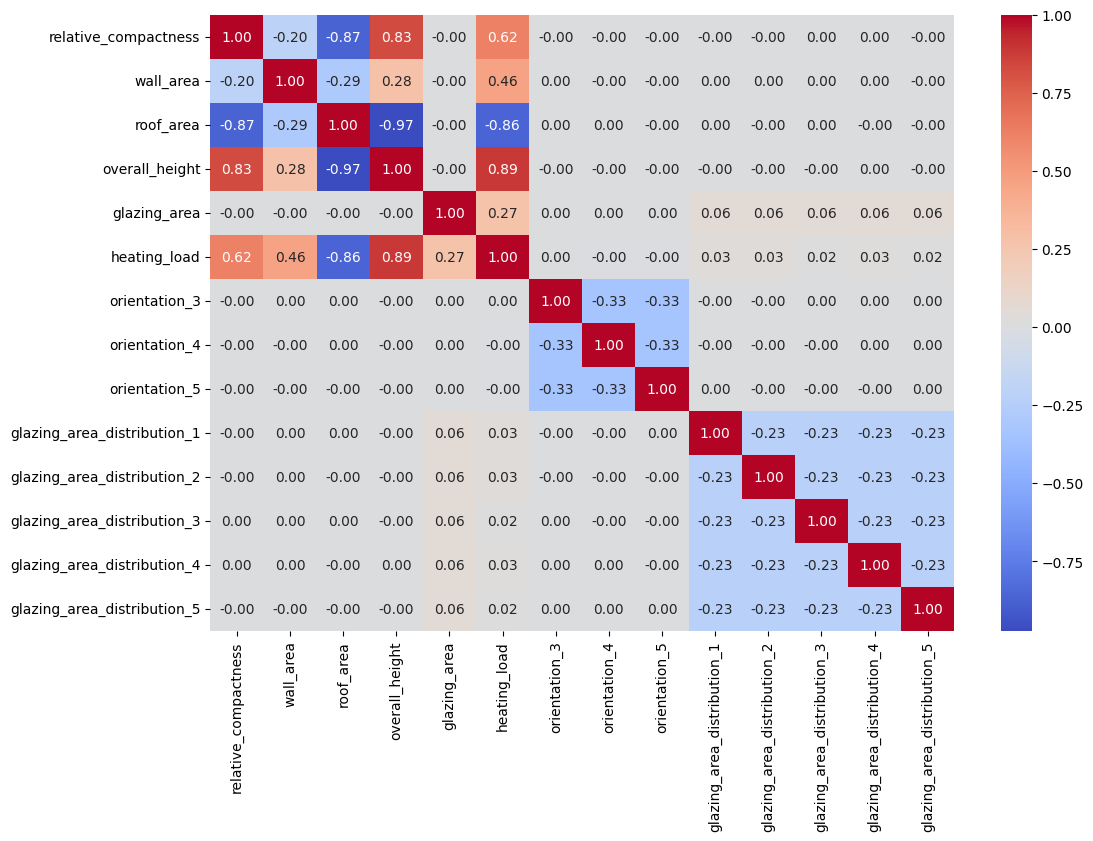

In [11]:
df.drop(columns=['surface_area', 'cooling_load'], inplace=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Based on the new correlation matrix, we can safely drop **Glazing Area** due to its weak positive correlation with our target variable. With it gone, our **Glazing Area Distribution** binary variables become redundant as well. With them gone, let us also remove the **Orientation** binary variables, which contrary to my initial assumptions, are not significant enough to our future model. Next, although **Relative Compactness** has a strong enough positive correlation with our target (0.62), it has an even stronger positive correlation with another feature, **Overall Height** (0.83). Since **Overall Height** has a stronger positive correlation with the target (0.89), it stays and **Relative Compactness** gets dropped. Next, **Wall Area** might not have a very strong correlation with the target (0.46), but we will keep it for now due to it not being strongly correlated with other features. **Roof Area** has a very strong negative correlation with **Overall Height** (-0.97), therefore it gets dropped as well. This only leaves us with two features, namely **Overall Height** and **Wall Area**.
<br><br><br>
With all of this behind us, let us begin working on our model.

In [12]:
X = df[['overall_height', 'wall_area']]
y = df['heating_load']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')

Mean Squared Error: 15.95
R2 Score: 0.85


MSE of 15.95 and R2 of 0.85 is not bad at all! Let us now try to improve our results through feature engineering.

In [14]:
X = df[['overall_height', 'wall_area']].copy()
X.loc[:, 'interaction'] = X['overall_height'] * X['wall_area']
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_features = poly.get_feature_names_out(input_features=X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=poly_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_poly_df.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')

Mean Squared Error: 14.07
R2 Score: 0.87


We improved our MSE to 14.07 and our R2 to 0.87!
<br><br><br>
Let us summarize. Our goal was to formulate a model that would predict the energy efficiency of a building based on its architectural features. We started with a dataset of 768 rows and 10 columns, 2 of which were target labels. Through statistical analysis and visualization, we narrowed down our feature set to two variables--overall height and wall area. We also decided to ignore one of the target variables due to their high correlation. To improve our model's accuracy, we then introduced interaction terms between our height and area. This allowed us to capture non-linear relationships. Our final model exhibits a fairly strong predictive capacity of 87% and ought to be fairly useful in practice.